Can machine learning models accurately predict air quality (AQI) to facilitate proactive health advisories and environmental planning in urban areas?

In [ ]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/bkosurma@gmu.edu/Filled_data-7.csv")

In [ ]:
from pyspark.sql.functions import col, count, when
columns_to_convert = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

# Converting columns to float
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast('float'))

df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- PM2_5: float (nullable = true)
 |-- PM10: float (nullable = true)
 |-- NO: float (nullable = true)
 |-- NO2: float (nullable = true)
 |-- NOx: float (nullable = true)
 |-- NH3: float (nullable = true)
 |-- CO: float (nullable = true)
 |-- SO2: float (nullable = true)
 |-- O3: float (nullable = true)
 |-- Benzene: float (nullable = true)
 |-- Toluene: float (nullable = true)
 |-- AQI: float (nullable = true)
 |-- AQI_Bucket: string (nullable = true)



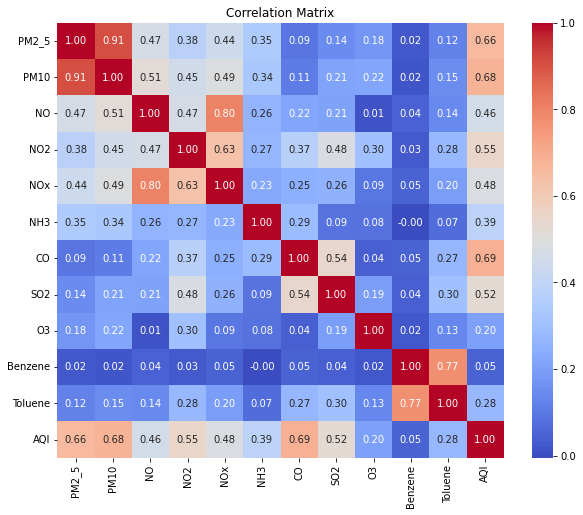

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
columns_to_use = [column for column in df.columns if column not in ['City', 'Date', 'AQI_Bucket']]
df = df.select(columns_to_use)

assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
feature_df = assembler.transform(df)

# Computing the values in the correlation matrix
corr_matrix = Correlation.corr(feature_df, "features").head()[0].toArray()

# Ploting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=df.columns, yticklabels=df.columns)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
import numpy as np

# Identifying columns to drop based on high correlation
drop_cols = set()
corr_abs = np.abs(corr_matrix)
for i in range(len(corr_abs)):
    for j in range(i+1, len(corr_abs)):
        if corr_abs[i, j] > 0.90:
            drop_cols.add(df.columns[j])

# Dropping highly correlated columns
df_filtered = df.drop(*drop_cols)

# Displaying the columns to be dropped
print(f"Columns to drop due to high correlation: {drop_cols}")

Columns to drop due to high correlation: {'PM10'}


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

initial_feature_columns = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

available_columns = df_filtered.columns
feature_columns = [col for col in initial_feature_columns if col in available_columns]
print(feature_columns)

# Assembling the remaining features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Standardizing the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initiating the Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="AQI")

# Pipeline setup
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Splitting the data into training and testing sets
train_data, test_data = df_filtered.randomSplit([0.8, 0.2], seed=42)

# Training the model
model = pipeline.fit(train_data)

# Making predictions
predictions = model.transform(test_data)

# Evaluating the model using RMSE and R2 as metrics
evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
evaluator_mae = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
r2_evaluator = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)


['PM2_5', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
Mean Absolute Error (MAE) on test data = 30.6918
Root Mean Squared Error (RMSE) on test data = 53.5122
R2 on test data = 0.859559


How does the combination of specific atmospheric pollutants influence the overall air quality index in urban environments, and can we predict variations in air quality levels based on these pollutants?

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initially specified feature columns
initial_feature_columns = ['PM2_5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']

# Determine which of these columns are still present in df_filtered
available_columns = df_filtered.columns
feature_columns = [col for col in initial_feature_columns if col in available_columns]
print(feature_columns)

# Assemble the remaining features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# StandardScaler is optional as RandomForest is not sensitive to magnitude of features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Initialize the Random Forest model
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="AQI", numTrees=100, seed=42)

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Split the data into training and testing sets
train_data, test_data = df_filtered.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluating the model using RMSE, MAE, and R2 as metrics
evaluator_rmse = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
evaluator_mae = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="mae")
mae = evaluator_mae.evaluate(predictions)
evaluator_r2 = RegressionEvaluator(labelCol="AQI", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print("Mean Absolute Error (MAE) on test data = %g" % mae)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R2 on test data = %g" % r2)


['PM2_5', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
Mean Absolute Error (MAE) on test data = 29.431
Root Mean Squared Error (RMSE) on test data = 50.4326
R2 on test data = 0.875259


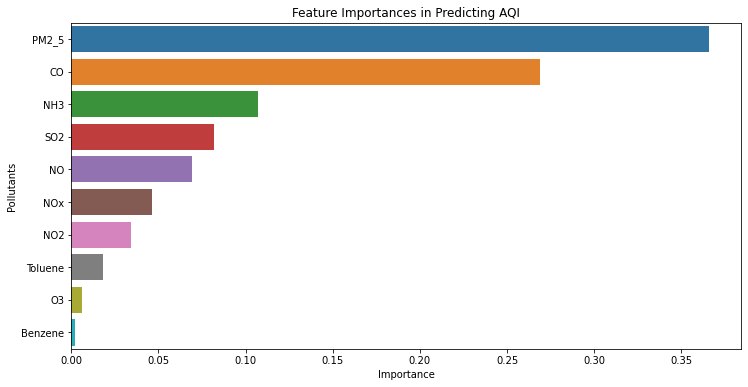

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extracting the feature importances
feature_importances = model.stages[-1].featureImportances.toArray()
features = feature_columns

# Creating a pandas DataFrame for better visualization
import pandas as pd
fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Feature Importances in Predicting AQI')
plt.xlabel('Importance')
plt.ylabel('Pollutants')
plt.show()
